In [1]:
from glob import glob
import cv2
import numpy as np
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
import tifffile as tf

from scipy import ndimage, signal
from skimage import morphology

import os
import pandas as pd

In [2]:
boundary = ndimage.generate_binary_structure(2,2).astype(int) - 2
boundary[1,1] = -(np.sum(boundary) + 1)

struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)

w = 5
its = 15
pad = its+10

mind = 50
buffx = 0
buffX = 1475
buffy = 200
buffz = 50
erode = [None for i in range(5)]
tapes = np.zeros(len(erode), dtype=int)

tolpx = 75
tolcoef = 1e-1

src = '../raw/'
dst = '../proc/plots/'

reference = pd.read_csv(src + 'reference_positions.csv')
reference.head()

,id,time,repetition,raw_shape_0,raw_shape_1,peaks_0,peaks_1,peaks_2,peaks_3,peaks_4,...,coef0_0,coef0_1,coef0_2,coef0_3,coef0_4,coef1_0,coef1_1,coef1_2,coef1_3,coef1_4
0,4pm_5,4pm,5,2752,4896,581,1474,2254,3039,3948,...,253.338113,191.960476,190.034391,166.621541,163.242478,-0.032295,0.006145,0.011285,0.020821,0.027724
1,12pm_1,12pm,1,2752,4896,770,1560,2420,2935,3742,...,221.196562,224.434227,247.078835,214.691579,199.458498,-0.018556,-0.028560,-0.053725,-0.011923,0.001635
2,12pm_2,12pm,2,2752,4896,811,1457,2193,2766,3577,...,220.067201,191.464608,212.659238,189.293204,192.507773,-0.015357,0.006335,-0.011776,0.003053,0.003911
3,12pm_3,12pm,3,2752,4896,654,1469,2273,3076,3890,...,212.449901,214.964818,232.525919,221.498919,217.392151,-0.011402,-0.013179,-0.024385,-0.030649,-0.014619
4,12pm_4,12pm,4,2752,4896,721,1530,2257,2945,3874,...,275.661410,229.471816,195.602945,152.918233,188.828204,-0.043672,-0.022881,0.001573,0.042187,0.002127


In [3]:
time = '4pm'
rep = 7

foldername = time + ' Inc Rep ' + str(rep)
filenames = glob(src + foldername + '/*.JPG')

nums = np.zeros(len(filenames), dtype=int) - 1
for i in range(len(nums)):
    num = os.path.splitext(os.path.split(filenames[i])[1])[0].split('(')[1][:-1]
    if num.isdigit():
        num = int(num)
        nums[i] = num
        
nums = np.argsort(nums)

            
ref = reference[reference.id == '{}_{}'.format(time,rep)].iloc[0]

In [4]:
idx = 329
if nums[idx] != -1:
    filename = filenames[nums[idx]]
    numidx = int(os.path.splitext(os.path.split(filename)[1])[0].split('(')[1][:-1])
    print(filename, numidx, sep='\t')
    
    raw = cv2.imread(filename)
    rawstd = np.var(raw, axis=2, ddof=1)
    rawmean = np.mean(raw, axis = 2)

    graw = raw[:,:,1]
    hsv = cv2.cvtColor(raw, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

../raw/4pm Inc Rep 7/4pm Inc Rep 7 (330).JPG	330


# Remove most of the background and foreground

In [5]:
stdmask = (rawstd > 60) | (rawmean > 210)

hmask = ((h < 40) & (h > 0)) & (v > 60) & stdmask

img = raw.copy()
for i in range(3):
    img[:,:,i] *= hmask

# Find the y-coord for the sticks

In [6]:
medians = np.median(raw[:,:,0], axis=0)[300: ]
peaks, foo = signal.find_peaks(255 - medians, distance=300, height=150, prominence=50)
peaks += 300
while len(peaks) < 6:
    peaks = np.hstack((peaks, [raw.shape[1]]))
peaks = peaks[:6]
print('Peaks (pre):\t', peaks)
for i in range(len(peaks)):
    foo = 'peaks_{}'.format(i)
    if np.abs(ref[foo] - peaks[i]) > tolpx:
        peaks[i] = ref[foo]

print('Peaks (post):\t', peaks)

Peaks (pre):	 [ 597 1296 2060 2926 3765 4683]
Peaks (post):	 [ 597 1296 2060 2926 3765 4513]


In [7]:
stick = [np.s_[buffx:buffX+buffx, peaks[i]-buffy:peaks[i]+buffy] for i in range(len(erode))]

for i in range(len(stick)):
    foo = np.quantile(graw[buffx:, peaks[i]-w:peaks[i]+w], 0.75)
    foo = np.min([90, foo])
    
    rmask = graw[stick[i]] < foo
    rmask = ndimage.median_filter(rmask, 11)
    rmask = np.pad(rmask, pad)

    bound = ndimage.convolve(rmask, boundary, mode='constant', cval=0)
    bound = ndimage.binary_dilation(bound, structure = struc2, iterations=its)

    fill = ndimage.binary_fill_holes(bound)
    erod = ndimage.binary_erosion(fill, structure = struc2, iterations=its//2, border_value=1)
    erode[i] = erod[pad:-pad, pad:-pad]
    
    tapes[i] = np.argmin(np.sum(erode[i][400:buffX], axis = 1)) + 400
print('Tapes (pre):\t', tapes)
for i in range(len(tapes)):
    foo = 'tapes_{}'.format(i)
    if np.abs(ref[foo] - tapes[i]) > tolpx:
        tapes[i] = ref[foo]

print('Tapes (post):\t', tapes)

Tapes (pre):	 [ 889  976 1047 1170 1371]
Tapes (post):	 [ 889  976 1047 1170 1371]


In [9]:
coef = np.zeros((len(erode), 2))
lightissue = False

for i in range(len(coef)):
    medial = np.zeros(len(erode[i]))    
    xvals = np.arange(len(medial))
    for j in range(200, len(medial)):
        foo = np.nonzero(erode[i][j])[0]
        if len(foo) > 10:
            medial[j] = np.median(foo)
    mask = medial > 0
    if np.sum(mask) < 300:
        lightissue = True
        break
    else:
        coef[i] = P.polyfit(xvals[mask], medial[mask], 1,full=False)
    
xvals = np.arange(len(raw))
lines = np.zeros((len(coef), len(xvals)))
for j in range(len(lines)):
    b0 = peaks[j] + coef[j,0] - buffy
    lines[j] = b0 + coef[j,1]*(xvals - buffx)

In [10]:
dp = np.zeros((len(tapes), 2))
plants = [ np.s_[buffx:tapes[0]+buffx, 0:peaks[1]-buffz] ]
dp[0] = [tapes[0], peaks[1]-buffz]

for i in range(1,len(tapes)):
    plants.append(np.s_[buffx:tapes[i]+buffx, peaks[i-1]+buffz:peaks[i+1]-buffz])
    dp[i,0] = tapes[i]
    dp[i,1] = (peaks[i+1]-buffz) - (peaks[i-1]+buffz)

In [11]:
print(dp[:,0]/dp[:,1])
Kp = np.min(dp[:,0]/dp[:,1])
print(tapes)
Xstartp = tapes - (Kp*dp[:,1]).astype(int)
Xstartp

[0.71348315 0.7160675  0.68431373 0.72897196 0.92199059]
[ 889  976 1047 1170 1371]


array([ 37,  44,   0,  72, 354])

In [12]:
plants = [ np.s_[Xstartp[0]:tapes[0], 0:peaks[1]-buffz] ]

for i in range(1,len(tapes)):
    plants.append(np.s_[Xstartp[i]:tapes[i], peaks[i-1]+buffz:peaks[i+1]-buffz])
plants

[(slice(37, 889, None), slice(0, 1246, None)),
 (slice(44, 976, None), slice(647, 2010, None)),
 (slice(0, 1047, None), slice(1346, 2876, None)),
 (slice(72, 1170, None), slice(2110, 3715, None)),
 (slice(354, 1371, None), slice(2976, 4463, None))]

In [13]:
err = np.zeros((img.shape[0], img.shape[1]), dtype = bool)

for j in range(len(erode)):
    bar = erode[j].copy()
    bar[tapes[j]:] = False
    foo = np.pad(bar, ((0,len(err) - len(erode[j])), (peaks[j]-buffy,err.shape[1]-peaks[j]-buffy)))
    err[foo] = True
print(err.shape, erode[j].shape, foo.shape, peaks[j], buffy)

(2752, 4896) (1475, 400) (2752, 4896) 3765 200


In [14]:
img = raw.copy()
for i in range(3):
    img[:,:,i] *= hmask

bar = img[:, :, ::-1].copy()
bar[err,0] = 186
bar[err,1] = 255
bar[err,2] = 255

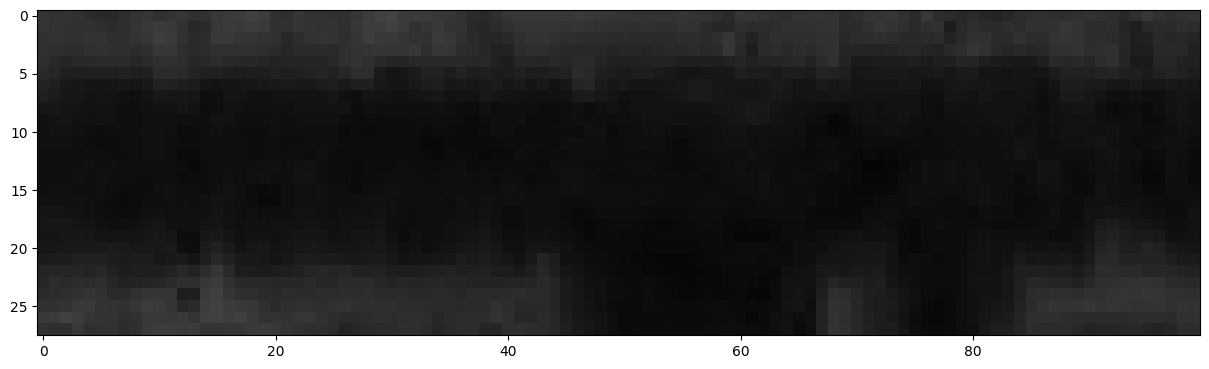

In [15]:


fig, ax = plt.subplots(1,1,figsize=(15,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

rx = 859
ax[0].imshow(raw[rx:rx+28, 4300:4400, ::-1], zorder=1)


In [21]:
scalebar = len(raw) - np.asarray([120, 120 + 28*2])

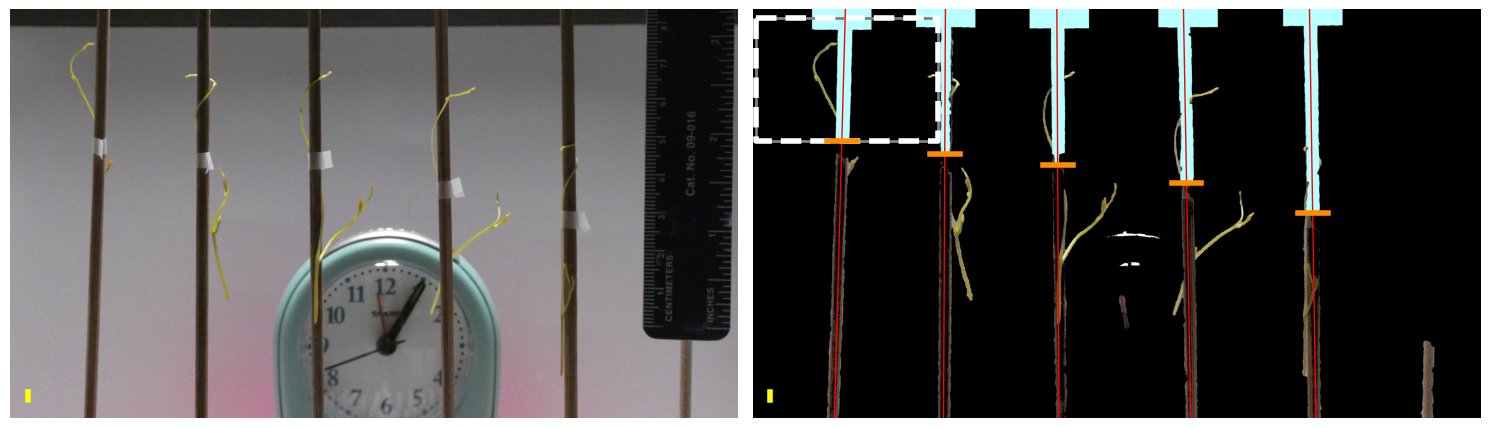

In [23]:
pidx = 0
xp = [plants[pidx][1].start+20, plants[pidx][1].stop, plants[pidx][1].stop, plants[pidx][1].start+20, plants[pidx][1].start+20]
yp = [plants[pidx][0].start+20, plants[pidx][0].start+20, plants[pidx][0].stop, plants[pidx][0].stop, plants[pidx][0].start+20]

fig, ax = plt.subplots(1,2,figsize=(15,5), sharex=True, sharey=True)
ax[0].imshow(raw[:, :, ::-1], zorder=1)
ax[1].imshow(bar, zorder=1)

ax[1].plot(xp, yp, c='gray', lw=2, zorder=4)
ax[1].plot(xp, yp, c='white', lw=4, ls='--', zorder=5)

for j in range(len(coef)):
    ax[1].plot(lines[j], xvals, c='red', lw=1, zorder=6)
    ax[1].plot([lines[j,tapes[j]]-100, lines[j,tapes[j]]+100], [buffx+tapes[j], buffx+tapes[j]], c='darkorange', lw=4, zorder=7)

for i in range(len(ax)):
    ax[i].plot([120,120], scalebar, c='yellow', lw=4, zorder=11)
    ax[i].axis('off')
    ax[i].margins(0)

fig.tight_layout()
filename = '{}{}_rep{}_{:04d}_full_h'.format(dst,time,rep,numidx)
#plt.savefig(filename + '.jpg', format='jpg', dpi=300, pil_kwargs={'optimize':True}, bbox_inches='tight')

In [24]:
fig, ax = plt.subplots(2,1,figsize=(12,10), sharex=True, sharey=True)
ax[0].imshow(raw[:, :, ::-1], zorder=1)
ax[1].imshow(bar, zorder=1)

ax[1].plot(xp, yp, c='gray', lw=2, zorder=4)
ax[1].plot(xp, yp, c='white', lw=4, ls='--', zorder=5)

for j in range(len(coef)):
    ax[1].plot(lines[j], xvals, c='red', lw=1, zorder=6)
    ax[1].plot([lines[j,tapes[j]]-100, lines[j,tapes[j]]+100], [buffx+tapes[j], buffx+tapes[j]], c='darkorange', lw=4, zorder=7)

for i in range(len(ax)):
    ax[i].plot([120,120], scalebar, c='yellow', lw=4, zorder=11)
    ax[i].axis('off')
    ax[i].margins(0)

fig.tight_layout()
filename = '{}{}_rep{}_{:04d}_full_v'.format(dst,time,rep,numidx)
#plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')
plt.close()

# Separate the sticks and cuscuta

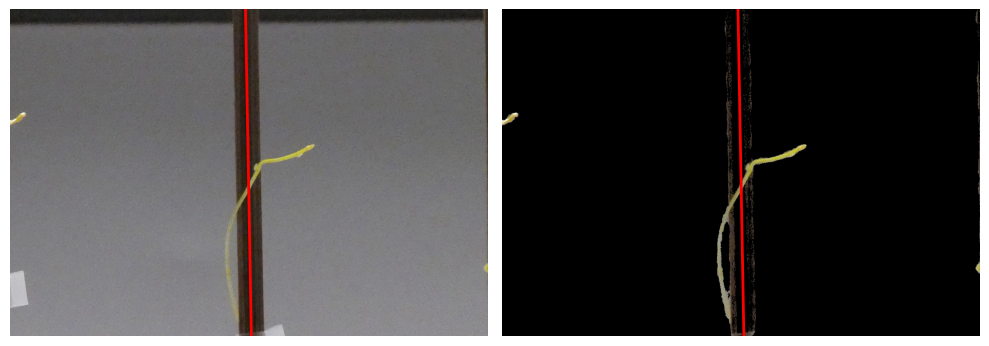

In [52]:
pidx = 3
anchory = peaks[pidx]-plants[pidx][1].start
xlen = xvals[ plants[pidx][0] ] - plants[pidx][0].start
line = lines[ pidx, plants[pidx][0] ] - plants[pidx][1].start
patch = img[plants[pidx]][:,:,::-1]

fig, ax = plt.subplots(2,1,figsize=(9,9), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(raw[plants[pidx]][:,:,::-1]);
ax[1].imshow(patch);

for i in range(2):
    ax[i].plot(line, xlen, color='r', lw=2);
    ax[i].axis('off')

fig.tight_layout()
filename = '{}{}_rep{}_plant{}_v01_{:04d}_v'.format(dst,time,rep,pidx,numidx)
#plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')
plt.close()

fig, ax = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(raw[plants[pidx]][:,:,::-1]);
ax[1].imshow(patch);

for i in range(2):
    ax[i].plot(line, xlen, color='r', lw=2);
    ax[i].axis('off')

fig.tight_layout()
filename = '{}{}_rep{}_plant{}_v01_{:04d}_h'.format(dst,time,rep,pidx,numidx)
#plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')

# Only keep the large chunks that are close to the central axis

In [53]:
median = ndimage.median_filter(patch[:,:,1], size=11)

skewer = np.zeros((len(line), 2*buffz))
for i in range(len(skewer)):
    foo = int(line[i])
    skewer[i] = patch[i, foo-buffz:foo+buffz, 1]
bar = np.sum(skewer > 0)/skewer.size
if len(skewer[skewer > 0]) < 10:
    bar = mind
else:
    foo = np.quantile(skewer[skewer > mind], 0.8)
    print(foo)
    foo = np.min([115, foo])
    bar = np.floor(mind + bar*(foo - mind))
median[median < bar] = 0
median[median > 0] = 1

labels,num = ndimage.label(median, structure=struc1)

107.0


In [54]:
minsize = 100
comp_size = np.zeros(num, dtype=int)
feret = np.zeros((num,2))
touch = np.zeros((num,4))
dtouch = np.zeros(num, dtype=int)

for i in range(num):
    box = median.copy()
    box[labels != i+1] = 0

    coords = np.asarray(np.nonzero(box))
    feret[i] = np.max(coords, axis=1) - np.min(coords, axis=1) + np.array([1,1])
    comp_size[i] = len(coords[1])
    
    foo = np.abs(line[coords[0]] - coords[1])
    
    bar = np.argmin(foo)
    dtouch[i] = foo[bar]
    touch[i,:2] = coords[:,bar]
    
f_ratio = np.divide(*np.sort(feret, axis=1).T)

comp_mask = ( (feret[:,1] > 30) | (f_ratio > 0.35) | (dtouch < 5) ) & (comp_size > 100) & (dtouch < 75) & (f_ratio > 0.075)

size_mask = comp_size/np.sum(comp_size[comp_mask]) > 0.06

mask = comp_mask & size_mask

box = np.zeros_like(labels).astype(bool)
comp_labels = np.nonzero(mask)[0]

for i in comp_labels:
    box[labels == i+1] = True

print(comp_size[comp_mask])
print(comp_size[comp_mask]/np.sum(comp_size[comp_mask]))

[13291   399   232]
[0.95467605 0.02865968 0.01666427]


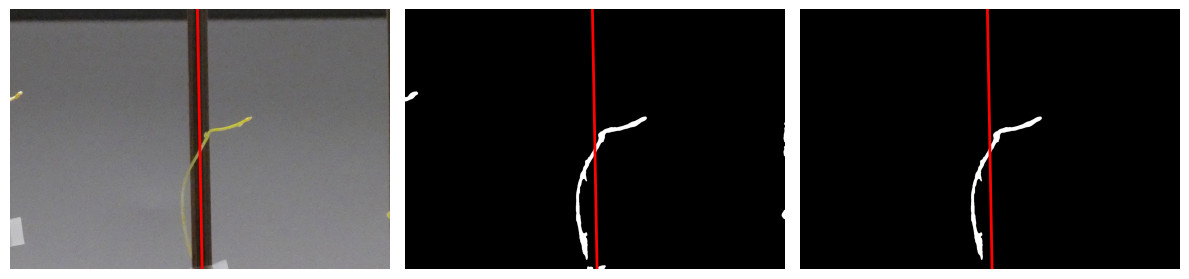

In [55]:
fig, ax = plt.subplots(3,1,figsize=(5,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(raw[plants[pidx]][:,:,::-1]);
ax[1].imshow(median, cmap='Greys_r', vmax=1)
ax[2].imshow(box, cmap='Greys_r', vmin=0, vmax=1)

for i in range(len(ax)):
    ax[i].plot(line, xlen, color='r', lw=2);
    ax[i].axis('off')

fig.tight_layout()
filename = '{}{}_rep{}_plant{}_v02_{:04d}_v'.format(dst,time,rep,pidx,numidx)
#plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')
plt.close()

fig, ax = plt.subplots(1,3,figsize=(12,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(raw[plants[pidx]][:,:,::-1]);
ax[1].imshow(median, cmap='Greys_r', vmax=1)
ax[2].imshow(box, cmap='Greys_r', vmin=0, vmax=1)

for i in range(len(ax)):
    ax[i].plot(line, xlen, color='r', lw=2);
    ax[i].axis('off')

fig.tight_layout()
filename = '{}{}_rep{}_plant{}_v02_{:04d}_h'.format(dst,time,rep,pidx,numidx)
#plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')

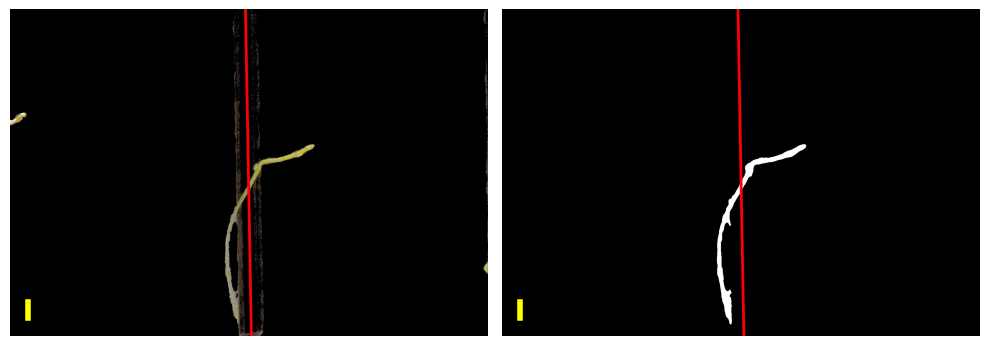

In [56]:
scalebar = len(patch) - np.asarray([60,60 + 28*2])
fig, ax = plt.subplots(2,1,figsize=(6,7), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(patch);
ax[1].imshow(box, cmap='Greys_r', vmin=0, vmax=1)

for i in range(len(ax)):
    ax[i].plot(line, xlen, color='r', lw=2);
    ax[i].axis('off')
    ax[i].plot([60,60], scalebar, c='yellow', lw=4, zorder=11)


fig.tight_layout()
filename = '{}{}_rep{}_plant{}_v03_{:04d}_v'.format(dst,time,rep,pidx,numidx)
plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')
plt.close()

fig, ax = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(patch);
ax[1].imshow(box, cmap='Greys_r', vmin=0, vmax=1)

for i in range(len(ax)):
    ax[i].plot(line, xlen, color='r', lw=2);
    ax[i].axis('off')
    ax[i].plot([60,60], scalebar, c='yellow', lw=4, zorder=11)

fig.tight_layout()
filename = '{}{}_rep{}_plant{}_v03_{:04d}_h'.format(dst,time,rep,pidx,numidx)
plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')

# Skeletonize and reduce box size

In [229]:
skel = morphology.thin(box)
ceros = np.zeros(4, dtype=int)
cero = np.nonzero(np.any(box, axis = 1))[0][np.asarray([0,-1])]
ceros[:2] = cero
print(ceros)
print(box.shape, skel.shape, erode[pidx].shape, peaks[pidx], anchory, buffy)
print(anchory-buffy, anchory+buffy)

comb = box[ceros[0]:ceros[1], : ].copy().astype(np.uint8)
comb[:, anchory-buffy:anchory+buffy] += 2*(erode[pidx][ceros[0]+plants[pidx][0].start:ceros[1]+plants[pidx][0].start, :]).astype(np.uint8)

cero = np.nonzero(np.any(comb != 0, axis = 0))[0][np.asarray([0,-1])]
ceros[2:] = cero
ss = np.s_[ceros[0]:ceros[1], ceros[2]:ceros[3]]
print(ss)

comb = comb[:, ceros[2]:ceros[3]]*2
comb[comb == 4] = 1
comb[comb == 2] = 2
comb[comb == 6] = 2
#comb[comb == 1] = 2 

comb[ skel[ss] ] += 2

coords = np.asarray(np.nonzero(skel[ss]))

[474 962   0   0]
(963, 1497) (963, 1497) (1475, 400) 3765 799 200
599 999
(slice(474, 962, None), slice(735, 857, None))


../proc/plots/4pm_rep7_plant4_v04_0330_h


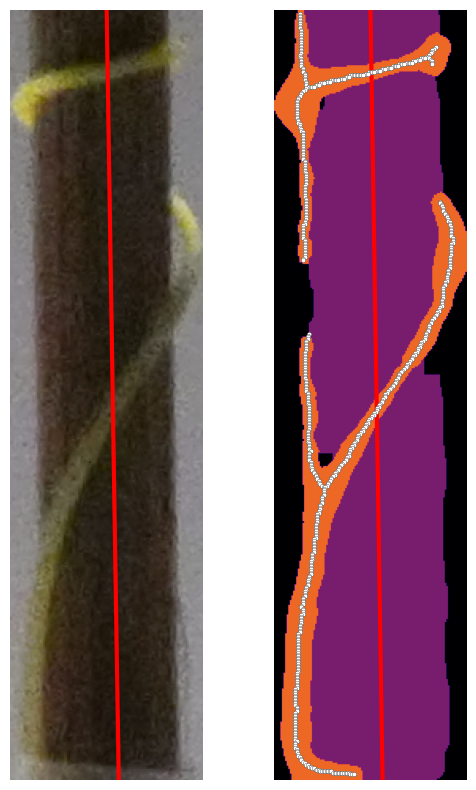

In [230]:
fig, ax = plt.subplots(1,2,figsize=(6,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(raw[plants[pidx]][ss][:,:,::-1], cmap='inferno', vmin=0);
ax[1].imshow(comb, cmap='inferno', vmin=0, vmax = 3, zorder = 2);

ax[1].scatter(coords[1], coords[0], c='w', zorder=5, s=10, edgecolor='k', linewidths=0.2)

for i in range(len(ax)):
    ax[i].plot(line[np.arange(ceros[0],ceros[1])] - ceros[2], range(ceros[1]-ceros[0]), color='red', lw=3);
    ax[i].axis('off')

fig.tight_layout()

filename = '{}{}_rep{}_plant{}_v04_{:04d}_h'.format(dst,time,rep,pidx,numidx)
print(filename)
plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')

In [151]:
#CC = [None for i in range(5)]
CC[pidx] = ceros
CC

[array([137, 685, 400, 666]),
 array([329, 733, 528, 742]),
 array([419, 976, 603, 818]),
 array([ 342,  945,  710, 1009]),
 array([474, 962, 735, 857])]

In [152]:
C = np.asarray(CC)
w = (C[:,3] - C[:,2])
h = (C[:,1] - C[:,0])
print(w/h)
K = np.max(w/h)
K

[0.48540146 0.52970297 0.38599641 0.49585406 0.25      ]


0.5297029702970297

In [231]:
print(int(K*h[pidx]))
print(w[pidx])
W = int(K*h[pidx]) - w[pidx]
print(W)

258
122
136


In [232]:
ceros = np.zeros(4, dtype=int)
cero = np.nonzero(np.any(box, axis = 1))[0][np.asarray([0,-1])]
ceros[:2] = cero
print(ceros)
print(box.shape, skel.shape, erode[pidx].shape, peaks[pidx], anchory, buffy)
print(anchory-buffy, anchory+buffy)

comb = box[ceros[0]:ceros[1], : ].copy().astype(np.uint8)
comb[:, anchory-buffy:anchory+buffy] += 2*(erode[pidx][ceros[0]+plants[pidx][0].start:ceros[1]+plants[pidx][0].start, :]).astype(np.uint8)

cero = np.nonzero(np.any(comb != 0, axis = 0))[0][np.asarray([0,-1])]
ceros[2:] = cero
ceros[2] -= W//2
ceros[3] += W//2

ss = np.s_[ceros[0]:ceros[1], ceros[2]:ceros[3]]
print(ss)

comb = comb[:, ceros[2]:ceros[3]]*2
comb[comb == 4] = 1
comb[comb == 2] = 2
comb[comb == 6] = 2
#comb[comb == 1] = 2 

comb[ skel[ss] ] += 2

coords = np.asarray(np.nonzero(skel[ss]))

[474 962   0   0]
(963, 1497) (963, 1497) (1475, 400) 3765 799 200
599 999
(slice(474, 962, None), slice(667, 925, None))


../proc/plots/4pm_rep7_plant4_v06_0330


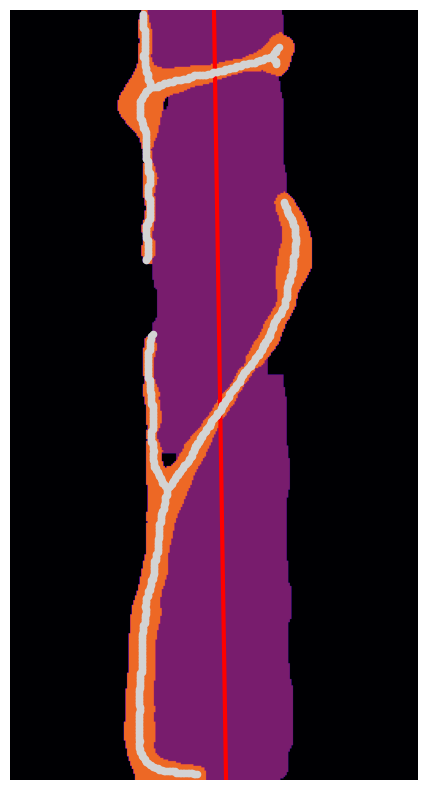

In [233]:
fig, ax = plt.subplots(1,1,figsize=(6,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

#ax[0].imshow(raw[plants[pidx]][ss][:,:,::-1], cmap='inferno', vmin=0);
ax[0].imshow(comb, cmap='inferno', vmin=0, vmax = 3, zorder = 2);
ax[0].scatter(coords[1], coords[0], c='lightgray', zorder=5, s=20)

for i in range(len(ax)):
    ax[i].plot(line[np.arange(ceros[0],ceros[1])] - ceros[2], range(ceros[1]-ceros[0]), color='red', lw=3);
    ax[i].axis('off')

fig.tight_layout()

filename = '{}{}_rep{}_plant{}_v06_{:04d}'.format(dst,time,rep,pidx,numidx)
print(filename)
plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')

../proc/plots/4pm_rep7_plant0_v06_0330_h


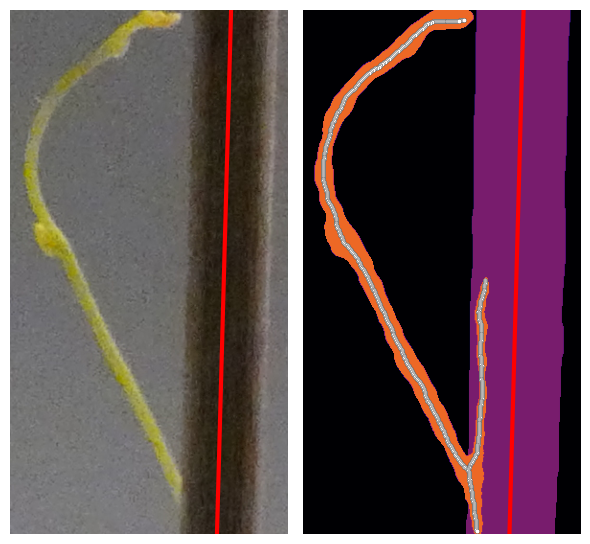

In [192]:
fig, ax = plt.subplots(1,2,figsize=(6,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(raw[plants[pidx]][ss][:,:,::-1], cmap='inferno', vmin=0);
ax[1].imshow(comb, cmap='inferno', vmin=0, vmax = 3, zorder = 2);

ax[1].scatter(coords[1], coords[0], c='w', zorder=5, s=10, edgecolor='k', linewidths=0.2)

for i in range(len(ax)):
    ax[i].plot(line[np.arange(ceros[0],ceros[1])] - ceros[2], range(ceros[1]-ceros[0]), color='red', lw=3);
    ax[i].axis('off')

fig.tight_layout()

filename = '{}{}_rep{}_plant{}_v06_{:04d}_h'.format(dst,time,rep,pidx,numidx)
print(filename)
plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')